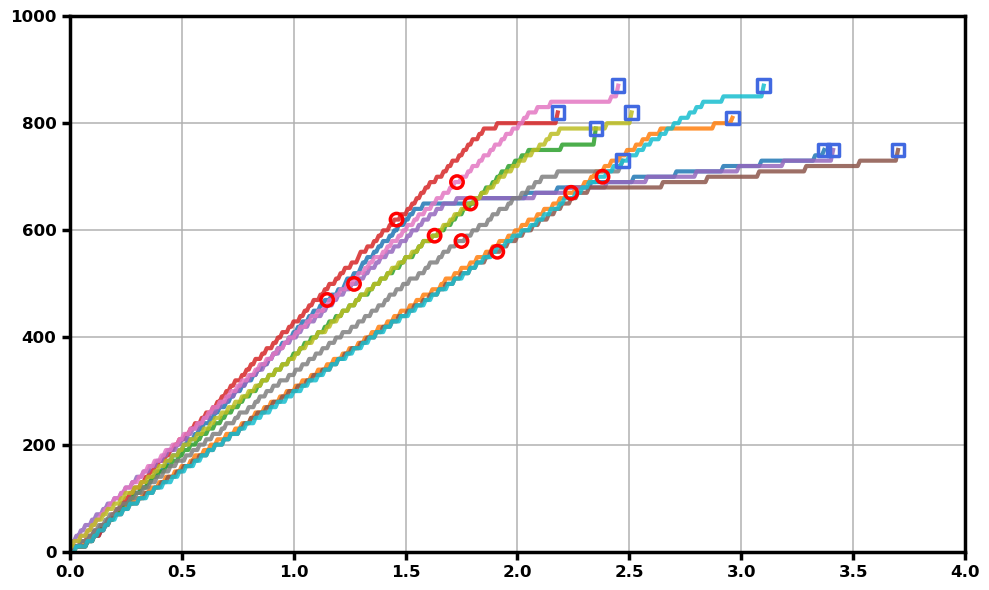

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import sys
from pathlib import Path

REPO_ROOT = Path('..').resolve()
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))

from utils.data_processing import DataProcessor, SWITCH_TOKEN, TERMINATION_TOKEN

def extract_times_weights(session, sample_period_ms=10):
    weights = []
    switch_idx = None
    termination_idx = None

    for raw in session.weight_sequence:
        if raw == SWITCH_TOKEN:
            switch_idx = len(weights) - 1  # switch happens after the last fast sample
            continue
        if raw == TERMINATION_TOKEN:
            termination_idx = len(weights) - 1 if weights else None
            break
        weights.append(raw)

    times = np.arange(len(weights)) * (sample_period_ms / 1000.0)
    if termination_idx is None and weights:
        termination_idx = len(weights) - 1  # final sample if no explicit token
    return np.array(times), np.array(weights), switch_idx, termination_idx

dp = DataProcessor()
dp.load_excel("../data/data.xlsx")
available_switches = sorted(dp.get_available_switch_points())

num_traces = min(10, len(available_switches))
np.random.seed(0)
selected_switches = np.random.choice(available_switches, num_traces, replace=False)

fig, ax = plt.subplots(figsize=(10, 6))

shown_switch_marker = False
shown_term_marker = False

for sp in selected_switches:
    session = dp.switch_point_clusters[sp][0]
    times, weights, switch_idx, term_idx = extract_times_weights(session)
    weights *= 10  # convert decigrams to grams, if needed
    label = f"Switch @ {sp} g"

    ax.plot(times, weights, linewidth=3.0, alpha=0.85)

    if switch_idx is not None and 0 <= switch_idx < len(times):
        ax.scatter(
            times[switch_idx],
            weights[switch_idx],
            marker="o",
            facecolor="none",
            edgecolor="red",
            linewidths=2.5,
            s=80,
            zorder=4,
        )
        shown_switch_marker = True

    if term_idx is not None and 0 <= term_idx < len(times):
        ax.scatter(
            times[term_idx],
            weights[term_idx],
            marker="s",
            facecolor="none",
            edgecolor="royalblue",
            linewidths=2.5,
            s=80,
            zorder=4,
        )
        shown_term_marker = True

for spine in ax.spines.values():
    spine.set_linewidth(2.5)

ax.tick_params(axis="both", width=2.5, length=6, labelsize=12) 
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight("bold")

# ax.set_xlabel("Time [s]")
# ax.set_ylabel("Weight [g]")
ax.grid(alpha=0.9, linewidth=1.2)
ax.set_xlim(0, 4.0)       # adjust as needed
ax.set_ylim(0, 1000)      # adjust as needed

plt.tight_layout()

fig.savefig(
    "/Users/omeremeksiz/Desktop/filling-control/rl-filling-control/notebooks/fillings.svg",
    bbox_inches="tight",
    transparent=True,
)
plt.show()
